In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import h5py
import numpy as np
import scipy.optimize
import jax.numpy as jnp

import proplot as pplt

## Look at n(z) Distributions and Perturbations

In [2]:
from des_y6_nz_modeling import sompz_integral

with h5py.File("N_gamma_alpha_v0.hdf5") as d:
    z = d["tomography/zbinsc"][:].astype(np.float64)
    z = np.concatenate([[0.0], z])
    
    nzs = {}
    for _bin in range(4):
        nzs[_bin] = d[f"tomography/bin{_bin}"][:].astype(np.float64)
        nzs[_bin] = np.concatenate([[0.0], nzs[_bin]])
        nzs[_bin] = nzs[_bin] / np.asarray(sompz_integral(nzs[_bin], z, 0, 6.0))

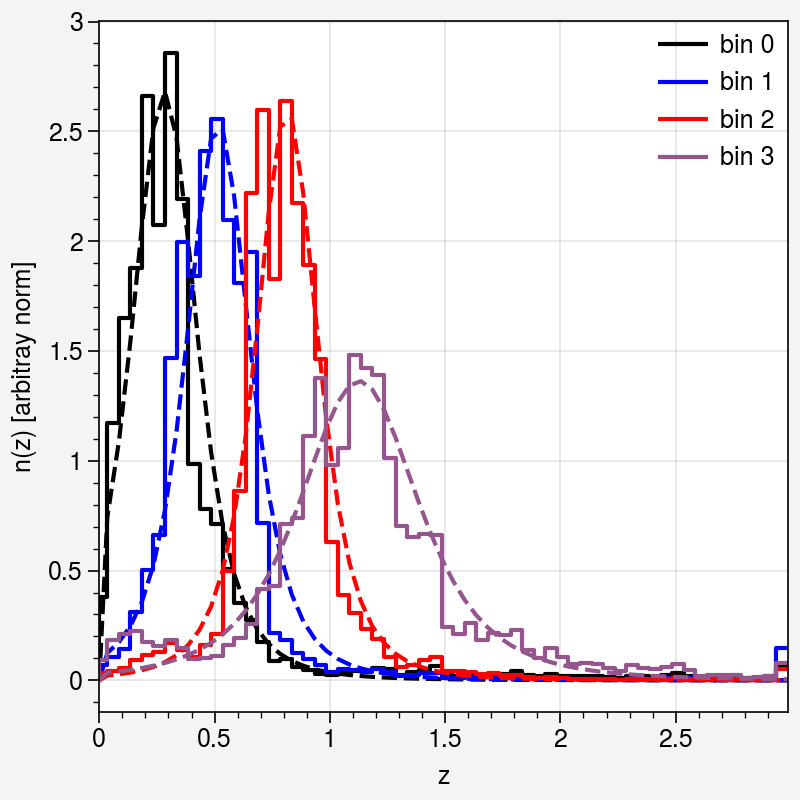

In [3]:
from des_y6_nz_modeling import fit_nz_data_for_template_params, mstudt_nrm, ZVALS

params = fit_nz_data_for_template_params(nzs)

fig, axs = pplt.subplots(figsize=(4, 4))

for i, col in enumerate(["black", "blue", "red", "purple"]):
    popt = params[i]
    axs.plot(z, nzs[i], drawstyle="steps", color=col, label=f"bin {i}")
    axs.plot(z, mstudt_nrm(z, *popt), linestyle="dashed", color=col)

axs.format(xlabel="z", ylabel="n(z) [arbitray norm]")
axs.legend(loc="ur", frameon=False, ncols=1)

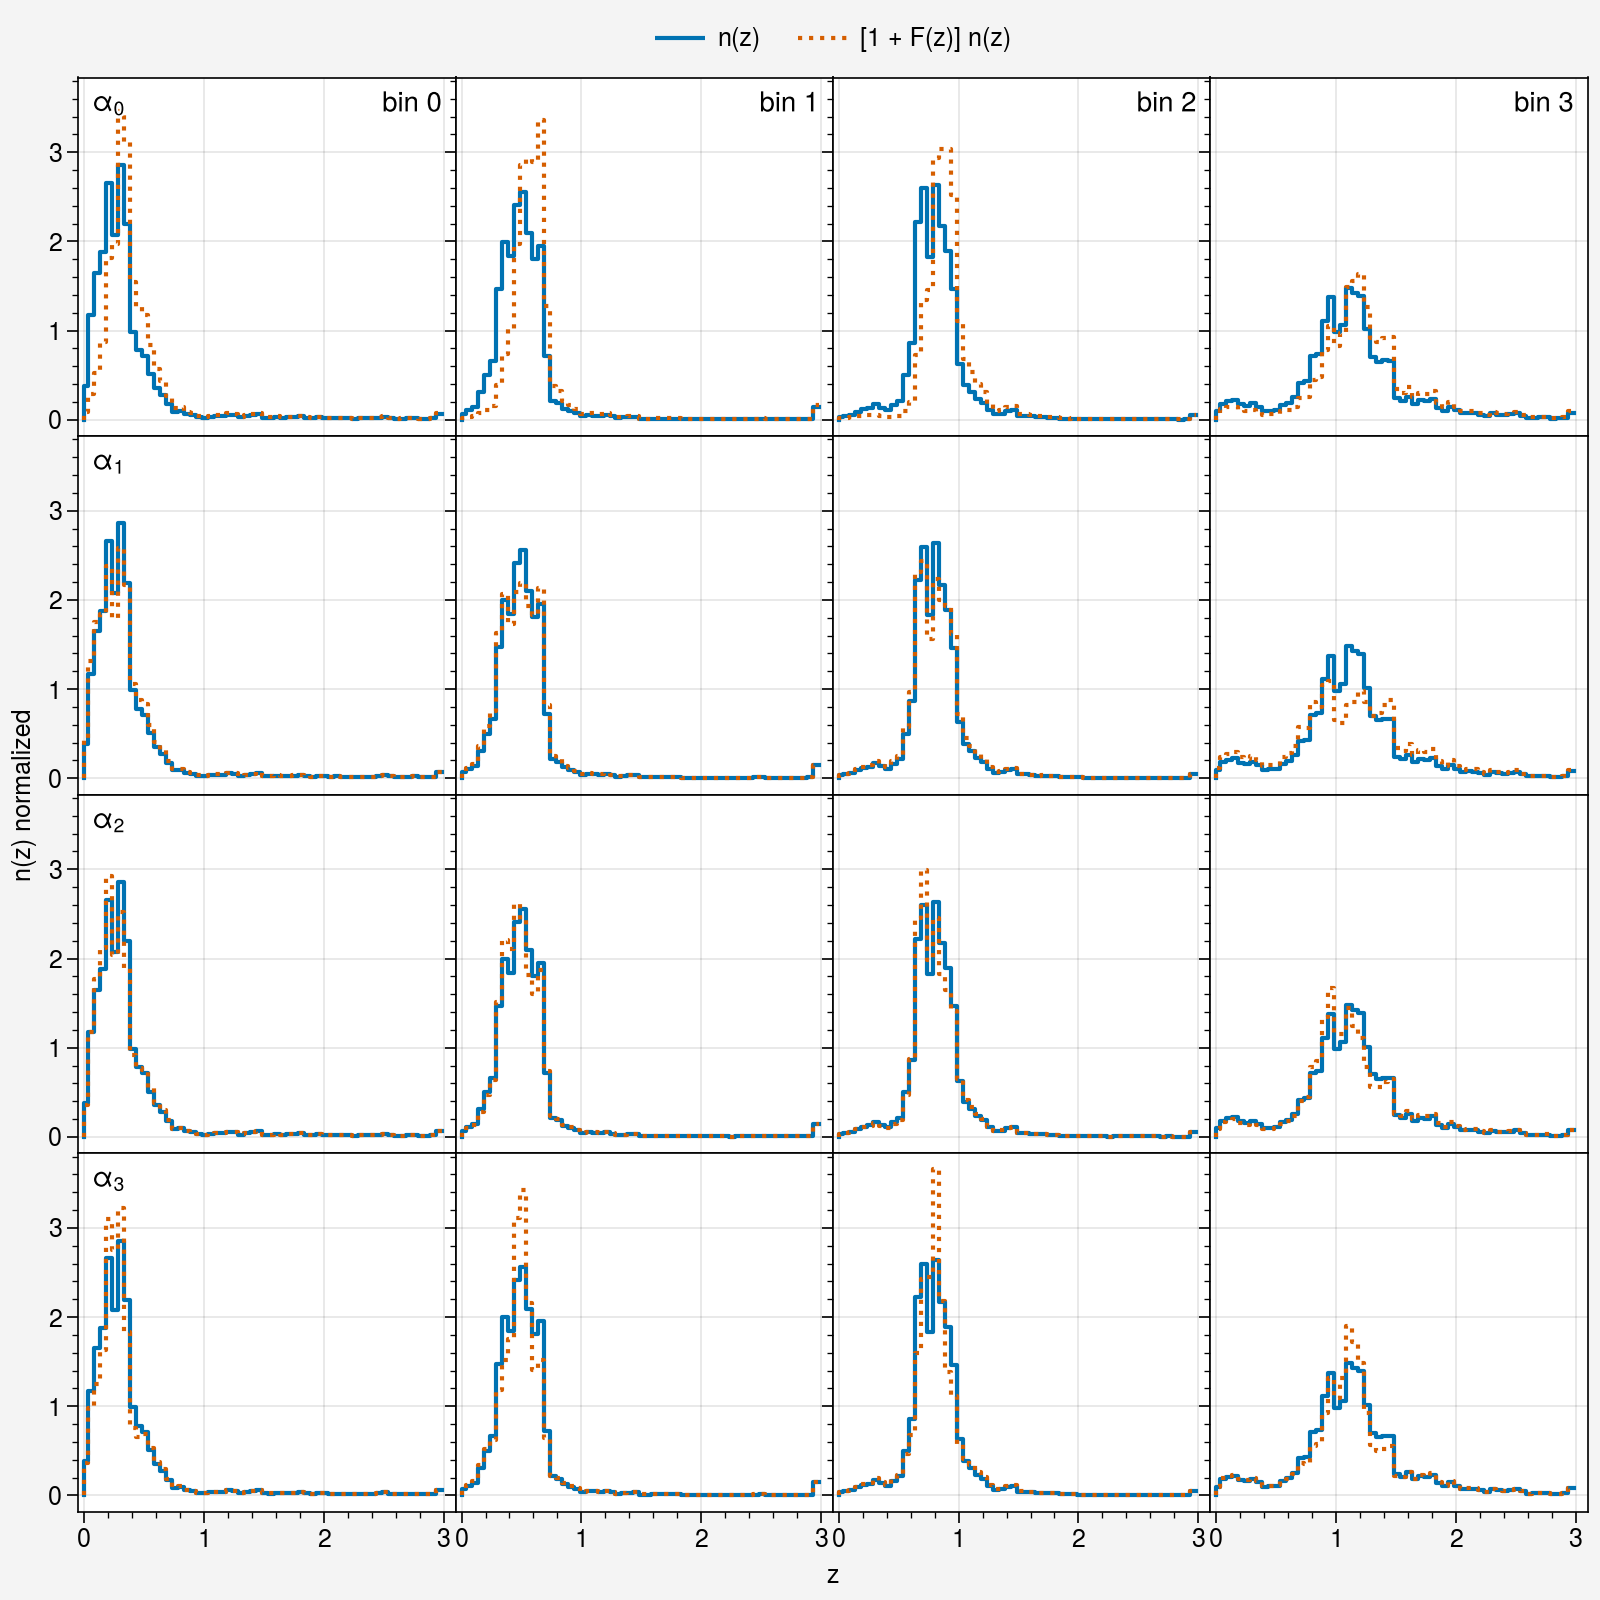

In [4]:
from des_y6_nz_modeling import fmodel_mstudt4

scales = np.array([1e-1, 5e-3, 1e-3, 5e-4])

fig, axs = pplt.subplots(ncols=4, nrows=4, figsize=(8, 8), share=4, wspace=0, hspace=0)

for i in range(4):
    for row in range(4):
        ax = axs[row, i]
        avec = np.zeros(4)
        avec[row] = scales[row]
        if i == 3 and row > 0:
            avec *= 10

        nzi = nzs[i]
        stud_params = params[i]

        morig = ax.plot(z, nzi, drawstyle="steps", label="n(z)")

        fac = 1.0 + fmodel_mstudt4(z, 0.0, avec[0], avec[1], avec[2], avec[3], stud_params[0], stud_params[1])
        nzi_fmodel = nzi * fac
        nzi_fmodel /= sompz_integral(nzi_fmodel, z, 0, 6)
        mmod = ax.plot(z, nzi_fmodel, drawstyle="steps", linestyle="dotted", label="[1 + F(z)] n(z)")

        # fac = 1.0 + fmodel_stud4(z, 0.0, 0e-1, 0e-3, 0e-3, 0e-4, stud_params[0], stud_params[1])
        # nzi_fmodel = nzi * fac
        # nzi_fmodel /= np.sum(nzi_fmodel)
        # mmod = ax.plot(z, nzi_fmodel, drawstyle="steps", linestyle="dotted", label="fmodel")

        # axs.plot(z, fac, linestyle="dotted")
        ax.format(xlim=(-0.05, 3.1))
        if row == 0:
            ax.format(urtitle=f"bin {i}")
        if i == 0:
            ax.format(ultitle=f"$\\alpha_{row}$", ylabel="n(z) normalized")
        if row == 3:
            ax.format(xlabel="z")

fig.legend([morig, mmod], loc="t", frameon=False, ncols=3)

## Fit the Model

In [49]:
with h5py.File("N_gamma_alpha_v0.hdf5") as d:
    mn = d["shear/mean"][:].astype(np.float64)
    cov = d["shear/cov"][:].astype(np.float64)
    mn_pars = tuple(tuple(v) for v in d["shear/mean_params"][:].astype(np.int64).tolist())
    zbins = []
    for zbin in range(-1, 10):
        zbins.append(d[f"alpha/bin{zbin}"][:].astype(np.float64))
    zbins = np.array(zbins)

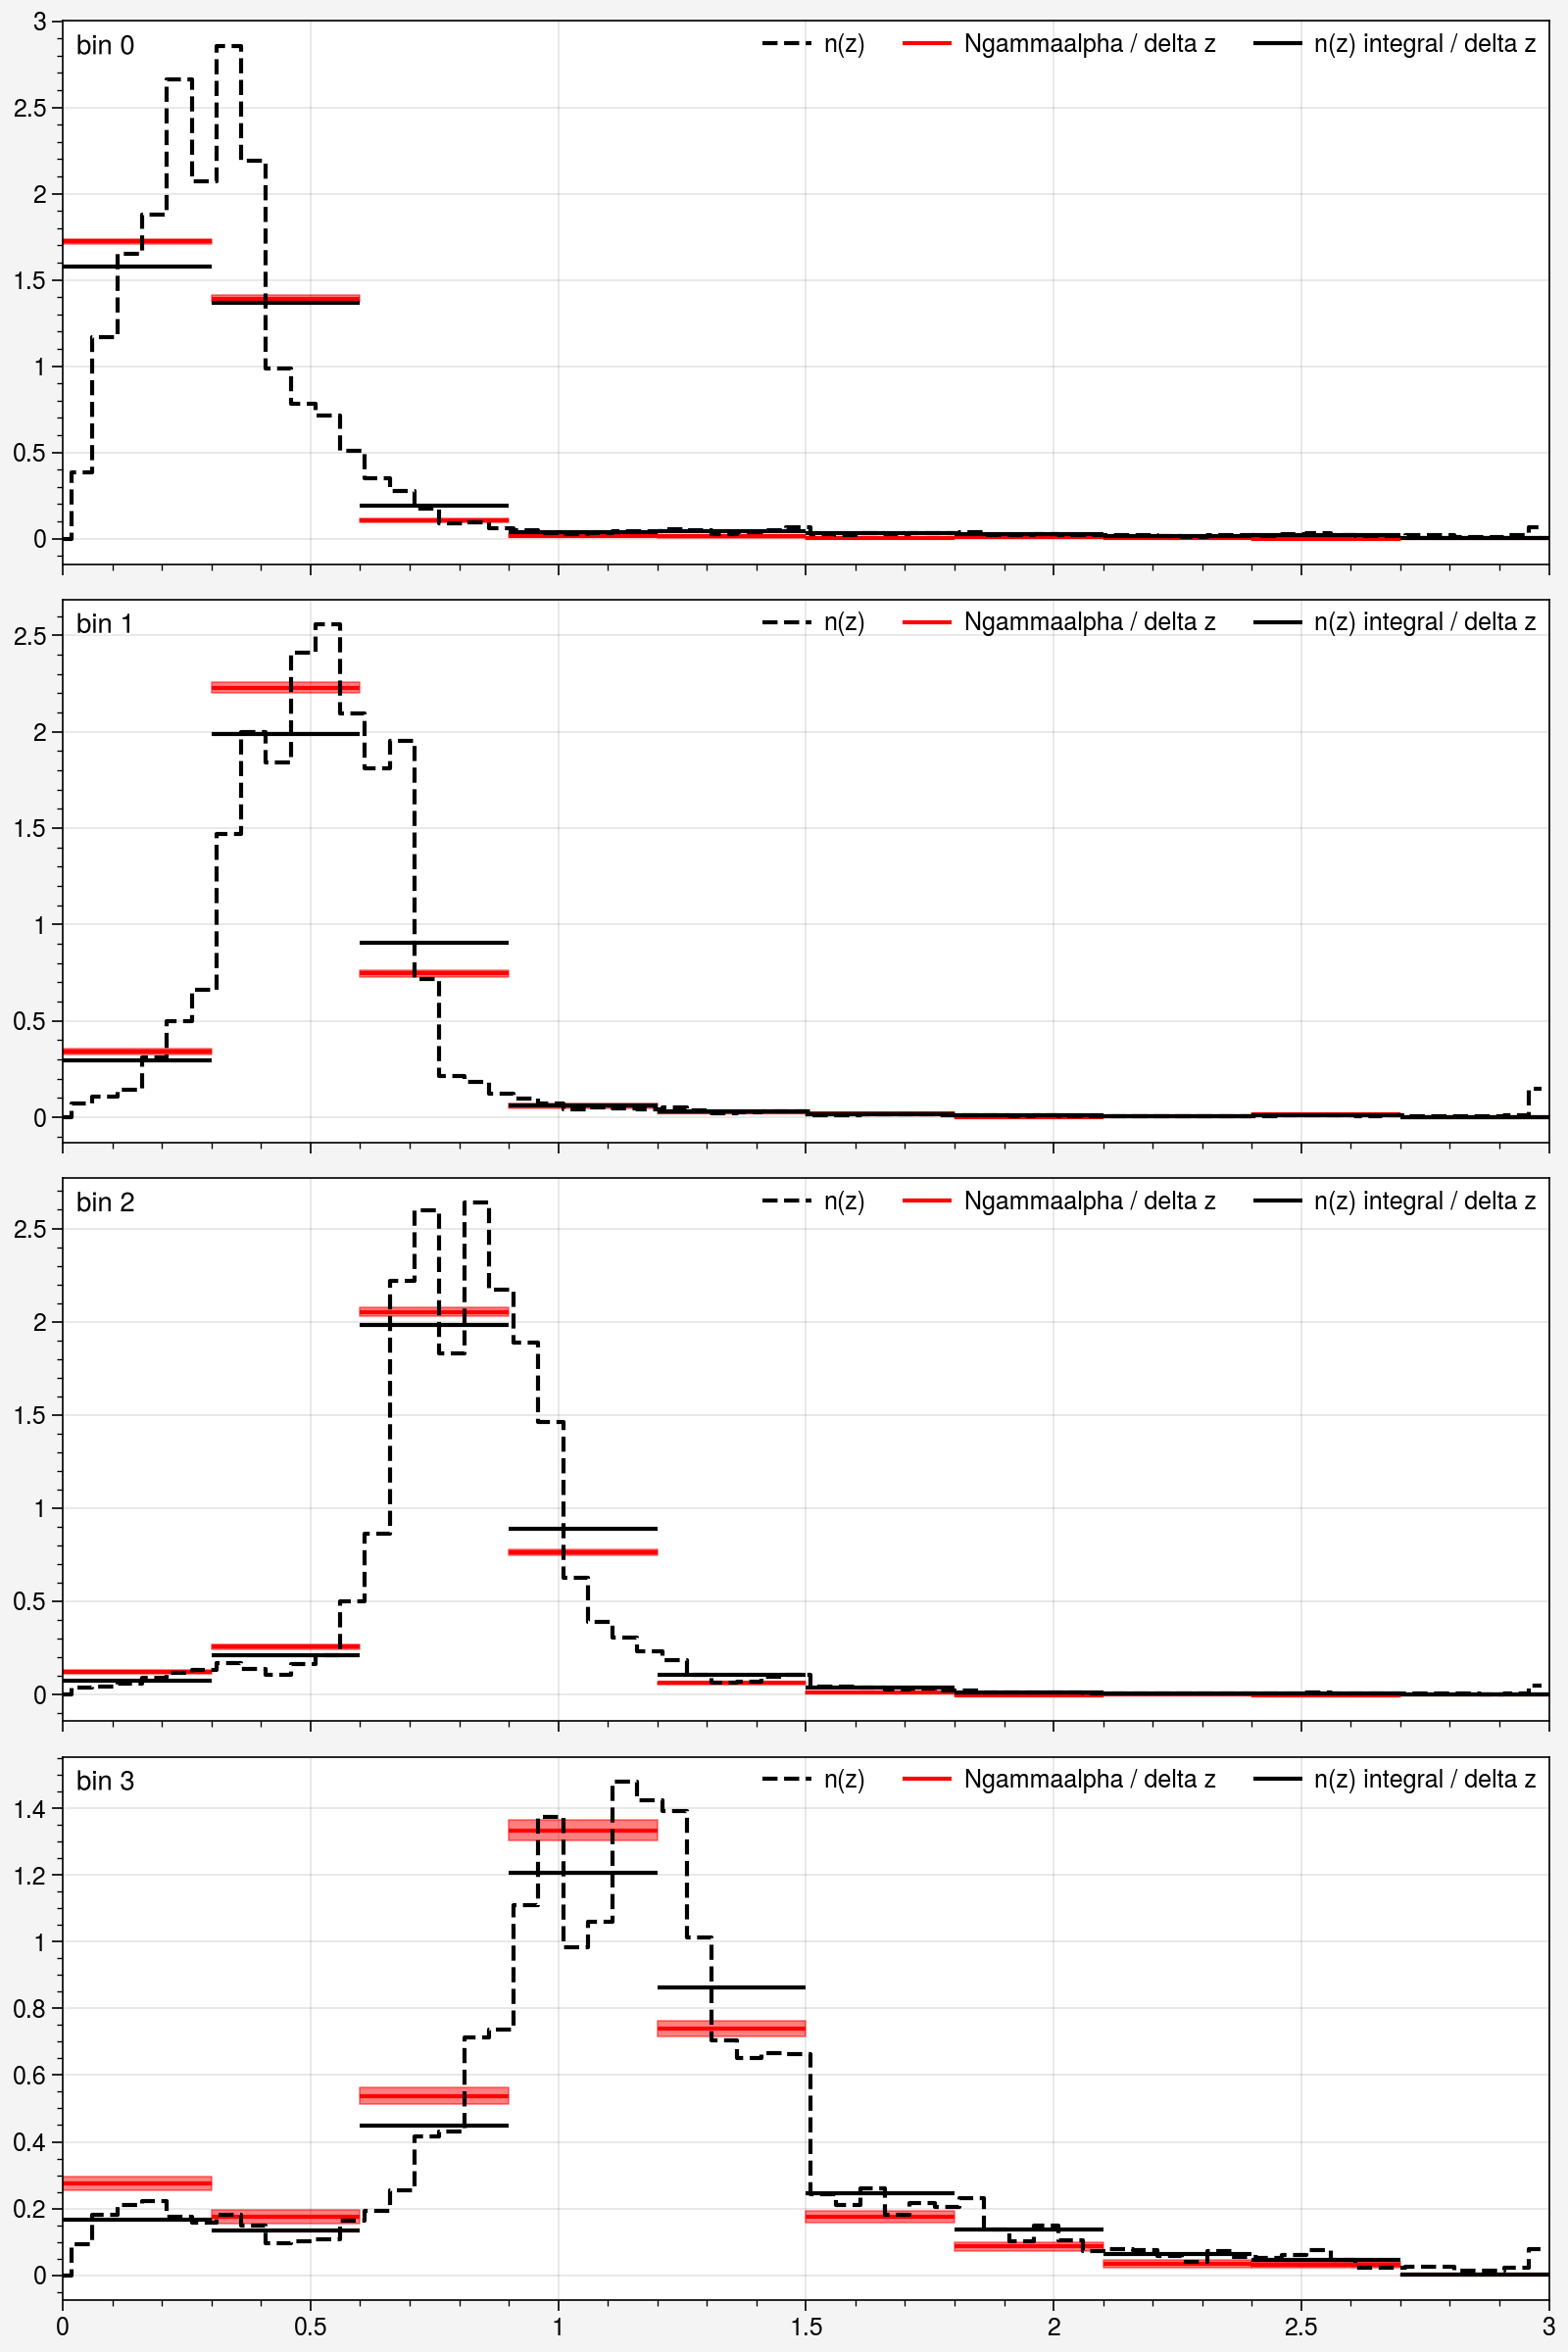

In [50]:
from des_y6_nz_modeling import sompz_integral

fig, axs = pplt.subplots(nrows=4, ncols=1, figsize=(8, 12))

for bi in range(4):
    ax = axs[bi, 0]
    ax.plot(ZVALS, nzs[bi], drawstyle="steps-mid", color="black", linestyle="dashed", label="n(z)")

    for i in range(10):
        nind = mn_pars.index((i, bi))
        bin_zmin, bin_zmax = zbins[i+1]
        bin_dz = bin_zmax - bin_zmin
        nga_val = mn[nind] / bin_dz
        nga_err = np.sqrt(cov[nind, nind]) / bin_dz
        ax.fill_between(
            [bin_zmin, bin_zmax],
            np.ones(2) * nga_val - nga_err,
            np.ones(2) * nga_val + nga_err,
            color="red",
            alpha=0.5,
        )
            
        ax.hlines(
            mn[nind] / bin_dz, 
            bin_zmin, 
            bin_zmax, 
            color="red",
            label="Ngammaalpha / delta z" if i == 0 else None,
        )
        ng_val = sompz_integral(nzs[bi], z, bin_zmin, bin_zmax) / bin_dz
        ax.hlines(
            ng_val, 
            bin_zmin, 
            bin_zmax, 
            color="black",
            label="n(z) integral / delta z" if i == 0 else None,
        )
    ax.legend(loc="ur", frameon=False)
    ax.format(xlim=(0,3), title=f"bin {bi}", titleloc="ul")
        

In [51]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [72]:
from functools import partial

from des_y6_nz_modeling import fmodel_mstudt4, gmodel_template_cosmos, ZVALS, sompz_integral


def model_mean(*, mu, sigma, z, nz, mn_pars, zbins, params, mn=None, cov=None):
    ngammas = []
    for i in range(4):
        a0 = params.get(f"a0_b{i}", 0.0)
        a1 = params.get(f"a1_b{i}", 0.0)
        a2 = params.get(f"a2_b{i}", 0.0)
        a3 = params.get(f"a3_b{i}", 0.0)
        a4 = params.get(f"a4_b{i}", 0.0)
        g = params.get(f"g_b{i}", 0.0)
    
        fmod = fmodel_mstudt4(z, a0, a1, a2, a3, a4, mu[i], sigma[i])
        gmod = g * gmodel_template_cosmos()
        ngamma = (1.0 + fmod) * nz[i] + gmod
        ngammas.append(ngamma)

    ngammas = jnp.stack(ngammas)

    def _scan_func(mn_pars, ind):
        si, bi = mn_pars[ind]
        zlow, zhigh = zbins[si+1]
        val = sompz_integral(ngammas[bi], z, zlow, zhigh)
        return mn_pars, val

    inds = jnp.arange(len(mn_pars))
    _, model = jax.lax.scan(_scan_func, mn_pars, inds)
    return model
    

def model(mu=None, sigma=None, z=None, nz=None, mn=None, cov=None, mn_pars=None, zbins=None):
    assert mu is not None
    assert sigma is not None
    assert nz is not None
    assert mn is not None
    assert cov is not None
    assert mn_pars is not None
    assert zbins is not None
    assert z is not None

    pwidth = numpyro.sample("sigma_coeff", dist.LogUniform(0.001, 10.0))
    params = {}
    for i in range(4):
        params[f"a0_b{i}"] = numpyro.sample(f"a0_b{i}", dist.Normal(0.0, pwidth))
        params[f"a1_b{i}"] = numpyro.sample(f"a1_b{i}", dist.Normal(0.0, pwidth))
        params[f"a2_b{i}"] = numpyro.sample(f"a2_b{i}", dist.Normal(0.0, pwidth))
        # params[f"a3_b{i}"] = numpyro.sample(f"a3_b{i}", dist.Normal(0.0, pwidth))
        # params[f"a4_b{i}"] = numpyro.sample(f"a4_b{i}", dist.Normal(0.0, pwidth))
        
        params[f"g_b{i}"] = numpyro.sample(f"g_b{i}", dist.Normal(0.0, pwidth))

    model_mn = model_mean(
        mu=mu, 
        sigma=sigma, 
        z=z, 
        nz=nz, 
        mn_pars=mn_pars, 
        zbins=zbins, 
        params=params,
    )
    numpyro.sample(f"model", dist.MultivariateNormal(loc=model_mn, covariance_matrix=cov), obs=mn)

In [73]:
model_data = dict(
    mu=tuple(params[i][0] for i in range(4)),
    sigma=tuple(params[i][1] for i in range(4)),
    z=z,
    nz=nzs,
    mn=mn,
    cov=cov,
    mn_pars=jnp.asarray(mn_pars, dtype=np.int32),
    zbins=jnp.asarray(zbins),
)

## MAP

In [74]:
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, autoguide

guide = autoguide.AutoDelta(model)
optimizer = numpyro.optim.Adam(0.001)
svi = SVI(model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(
    random.PRNGKey(42),
    100000,
    **model_data,
)
map_params = svi_results.params

for key in list(map_params.keys()):
    if key.endswith("_auto_loc"):
        new_key = key[:-len("_auto_loc")]
        map_params[new_key] = map_params[key]
        del map_params[key]
print(map_params)

100%|████████████████████████████████████████████████████████████████| 100000/100000 [00:12<00:00, 7808.65it/s, init loss: 6946.7354, avg. loss [95001-100000]: -155.8101]


{'a0_b0': Array(0.00099433, dtype=float64), 'a0_b1': Array(0.01512949, dtype=float64), 'a0_b2': Array(-0.01116094, dtype=float64), 'a0_b3': Array(-0.01241068, dtype=float64), 'a1_b0': Array(-0.00396332, dtype=float64), 'a1_b1': Array(-0.02926506, dtype=float64), 'a1_b2': Array(-0.02047378, dtype=float64), 'a1_b3': Array(-0.05768793, dtype=float64), 'a2_b0': Array(-0.01468733, dtype=float64), 'a2_b1': Array(-0.00153563, dtype=float64), 'a2_b2': Array(-0.00086808, dtype=float64), 'a2_b3': Array(-0.00909852, dtype=float64), 'g_b0': Array(-0.04117596, dtype=float64), 'g_b1': Array(-0.02340944, dtype=float64), 'g_b2': Array(0.02272438, dtype=float64), 'g_b3': Array(0.05262531, dtype=float64), 'sigma_coeff': Array(0.0253907, dtype=float64)}


In [75]:
model_mn = model_mean(
    params=params,
    **model_data,
)
dmn = model_mn - mn
chi2 = np.dot(dmn, np.dot(np.linalg.inv(cov), dmn.T))
print("chi2:", chi2)
print("dof:", mn.shape[0] - len(map_params))

chi2: 1230.3782427318376
dof: 27


## Make a Plot

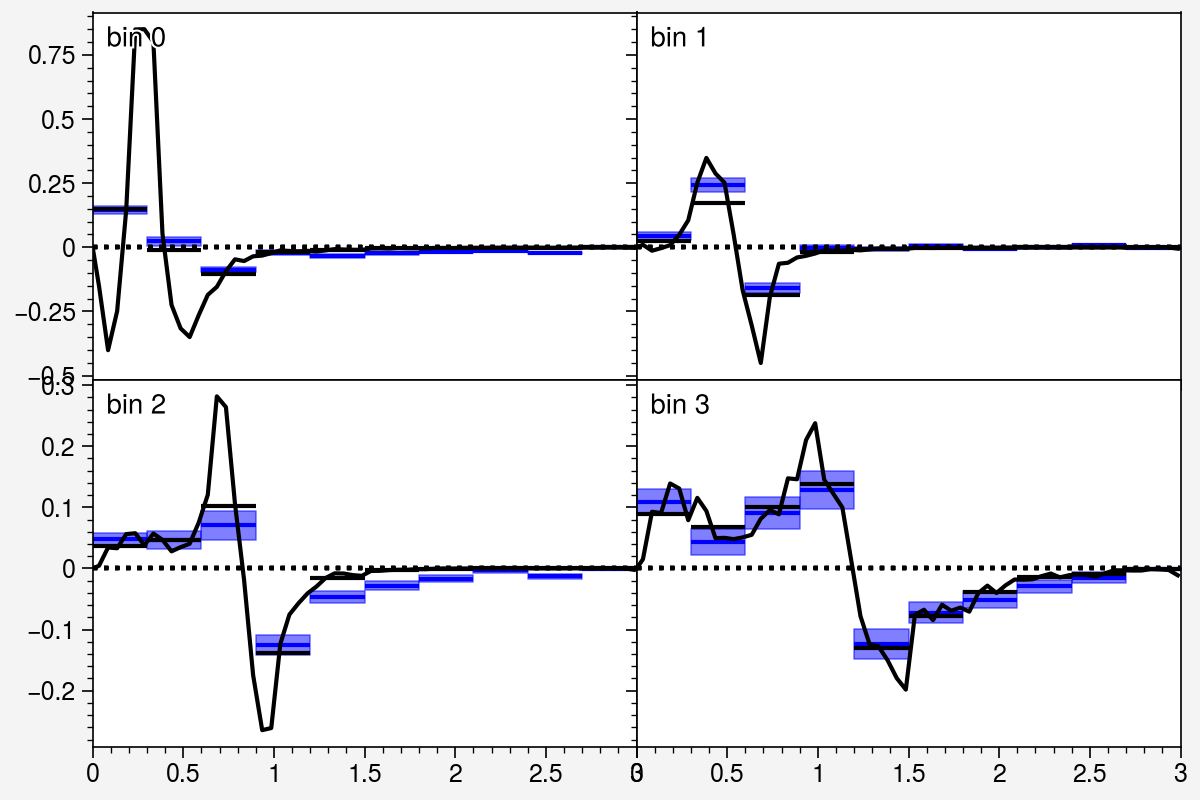

In [76]:
fig, axs = pplt.subplots(nrows=2, ncols=2, figsize=(6, 4), wspace=0, hspace=0)

sub_nmcal = 1

for bi in range(4):
    biy, bix = np.unravel_index(bi, (2, 2))
    ax = axs[biy, bix]

    fmod = fmodel_mstudt4(
        ZVALS,
        map_params[f"a0_b{bi}"],
        map_params[f"a1_b{bi}"],
        map_params[f"a2_b{bi}"],
        map_params.get(f"a3_b{bi}", 0.0),
        map_params.get(f"a4_b{bi}", 0.0),
        params[bi][0],
        params[bi][1],
    )
    gmod = map_params[f"g_b{bi}"] * gmodel_template_cosmos()
    ngamma = (1.0 + fmod) * nzs[bi] + gmod

    if not sub_nmcal:
        ax.plot(ZVALS, nzs[bi], drawstyle="steps-mid", label="n(z)", color="purple", linestyle="dashed")
        ax.plot(ZVALS, ngamma , drawstyle="steps-mid", label="n_gamma(z)", color="black")
    else:
        ax.plot(z, ngamma - sub_nmcal * nzs[bi], color="black")
    for i in range(10):
        nind = mn_pars.index((i, bi))
        bin_zmin, bin_zmax = zbins[i+1]
        bin_dz = bin_zmax - bin_zmin

        nmcal_val = sompz_integral(nzs[bi], z, bin_zmin, bin_zmax) / bin_dz
        if not sub_nmcal:
            ax.hlines(
                nmcal_val, 
                bin_zmin, 
                bin_zmax, 
                color="purple",
                # label="n(z) integral / delta z" if i == 0 else None,
            )
        
        nga_val = mn[nind] / bin_dz - sub_nmcal * nmcal_val
        nga_err = np.sqrt(cov[nind, nind]) / bin_dz
        ax.fill_between(
            [bin_zmin, bin_zmax],
            np.ones(2) * nga_val - nga_err,
            np.ones(2) * nga_val + nga_err,
            color="blue",
            alpha=0.5,
        )
                
        ax.hlines(
            mn[nind] / bin_dz - sub_nmcal * nmcal_val, 
            bin_zmin, 
            bin_zmax, 
            color="blue",
            label="Ngammaalpha / delta z" if i == 0 else None,
        )
                
        ng_val = sompz_integral(ngamma, z, bin_zmin, bin_zmax) / bin_dz
        ax.hlines(ng_val - sub_nmcal * nmcal_val, bin_zmin, bin_zmax, color="black")
    
        # ax.axvline(bin_zmin, color="black", linestyle="dotted")
        ax.axhline(0.0, color="black", linestyle="dotted")
        ax.grid(False)
    # ax.legend(loc="top", frameon=False)
    ax.format(xlim=(0,3), title=f"bin {bi}", titleloc="ul")

    # ax.plot(ZVALS, mstudt_nrm(ZVALS, *params[bi]) / DZ - offset * nzs_norm[bi], linestyle="dashed", color="blue")

# MCMC

In [77]:
from jax import random
from numpyro.infer import init_to_sample

rng_key = random.PRNGKey(42)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model, init_strategy=init_to_sample(), dense_mass=True)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key_,
    **model_data,
)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 528.37it/s, 15 steps of size 1.69e-01. acc. prob=0.89]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
        a0_b0      0.01      0.02      0.01     -0.03      0.05   1111.10      1.00
        a0_b1      0.03      0.02      0.02     -0.01      0.06   1081.95      1.00
        a0_b2     -0.01      0.01     -0.01     -0.03      0.01   1330.14      1.00
        a0_b3     -0.02      0.02     -0.02     -0.04      0.01   1762.79      1.00
        a1_b0     -0.00      0.00     -0.00     -0.01     -0.00   2195.76      1.00
        a1_b1     -0.03      0.00     -0.03     -0.04     -0.02   1392.47      1.00
        a1_b2     -0.02      0.00     -0.02     -0.03     -0.01   2026.41      1.00
        a1_b3     -0.06      0.01     -0.06     -0.07     -0.05   1781.73      1.00
        a2_b0     -0.01      0.00     -0.01     -0.02     -0.01   1377.48      1.00
        a2_b1     -0.00      0.00     -0.00     -0.00      0.00   1304.15      1.00
        a2_b2     -0.00      0.00     -0.00     -0.00      0.00   1758.15  

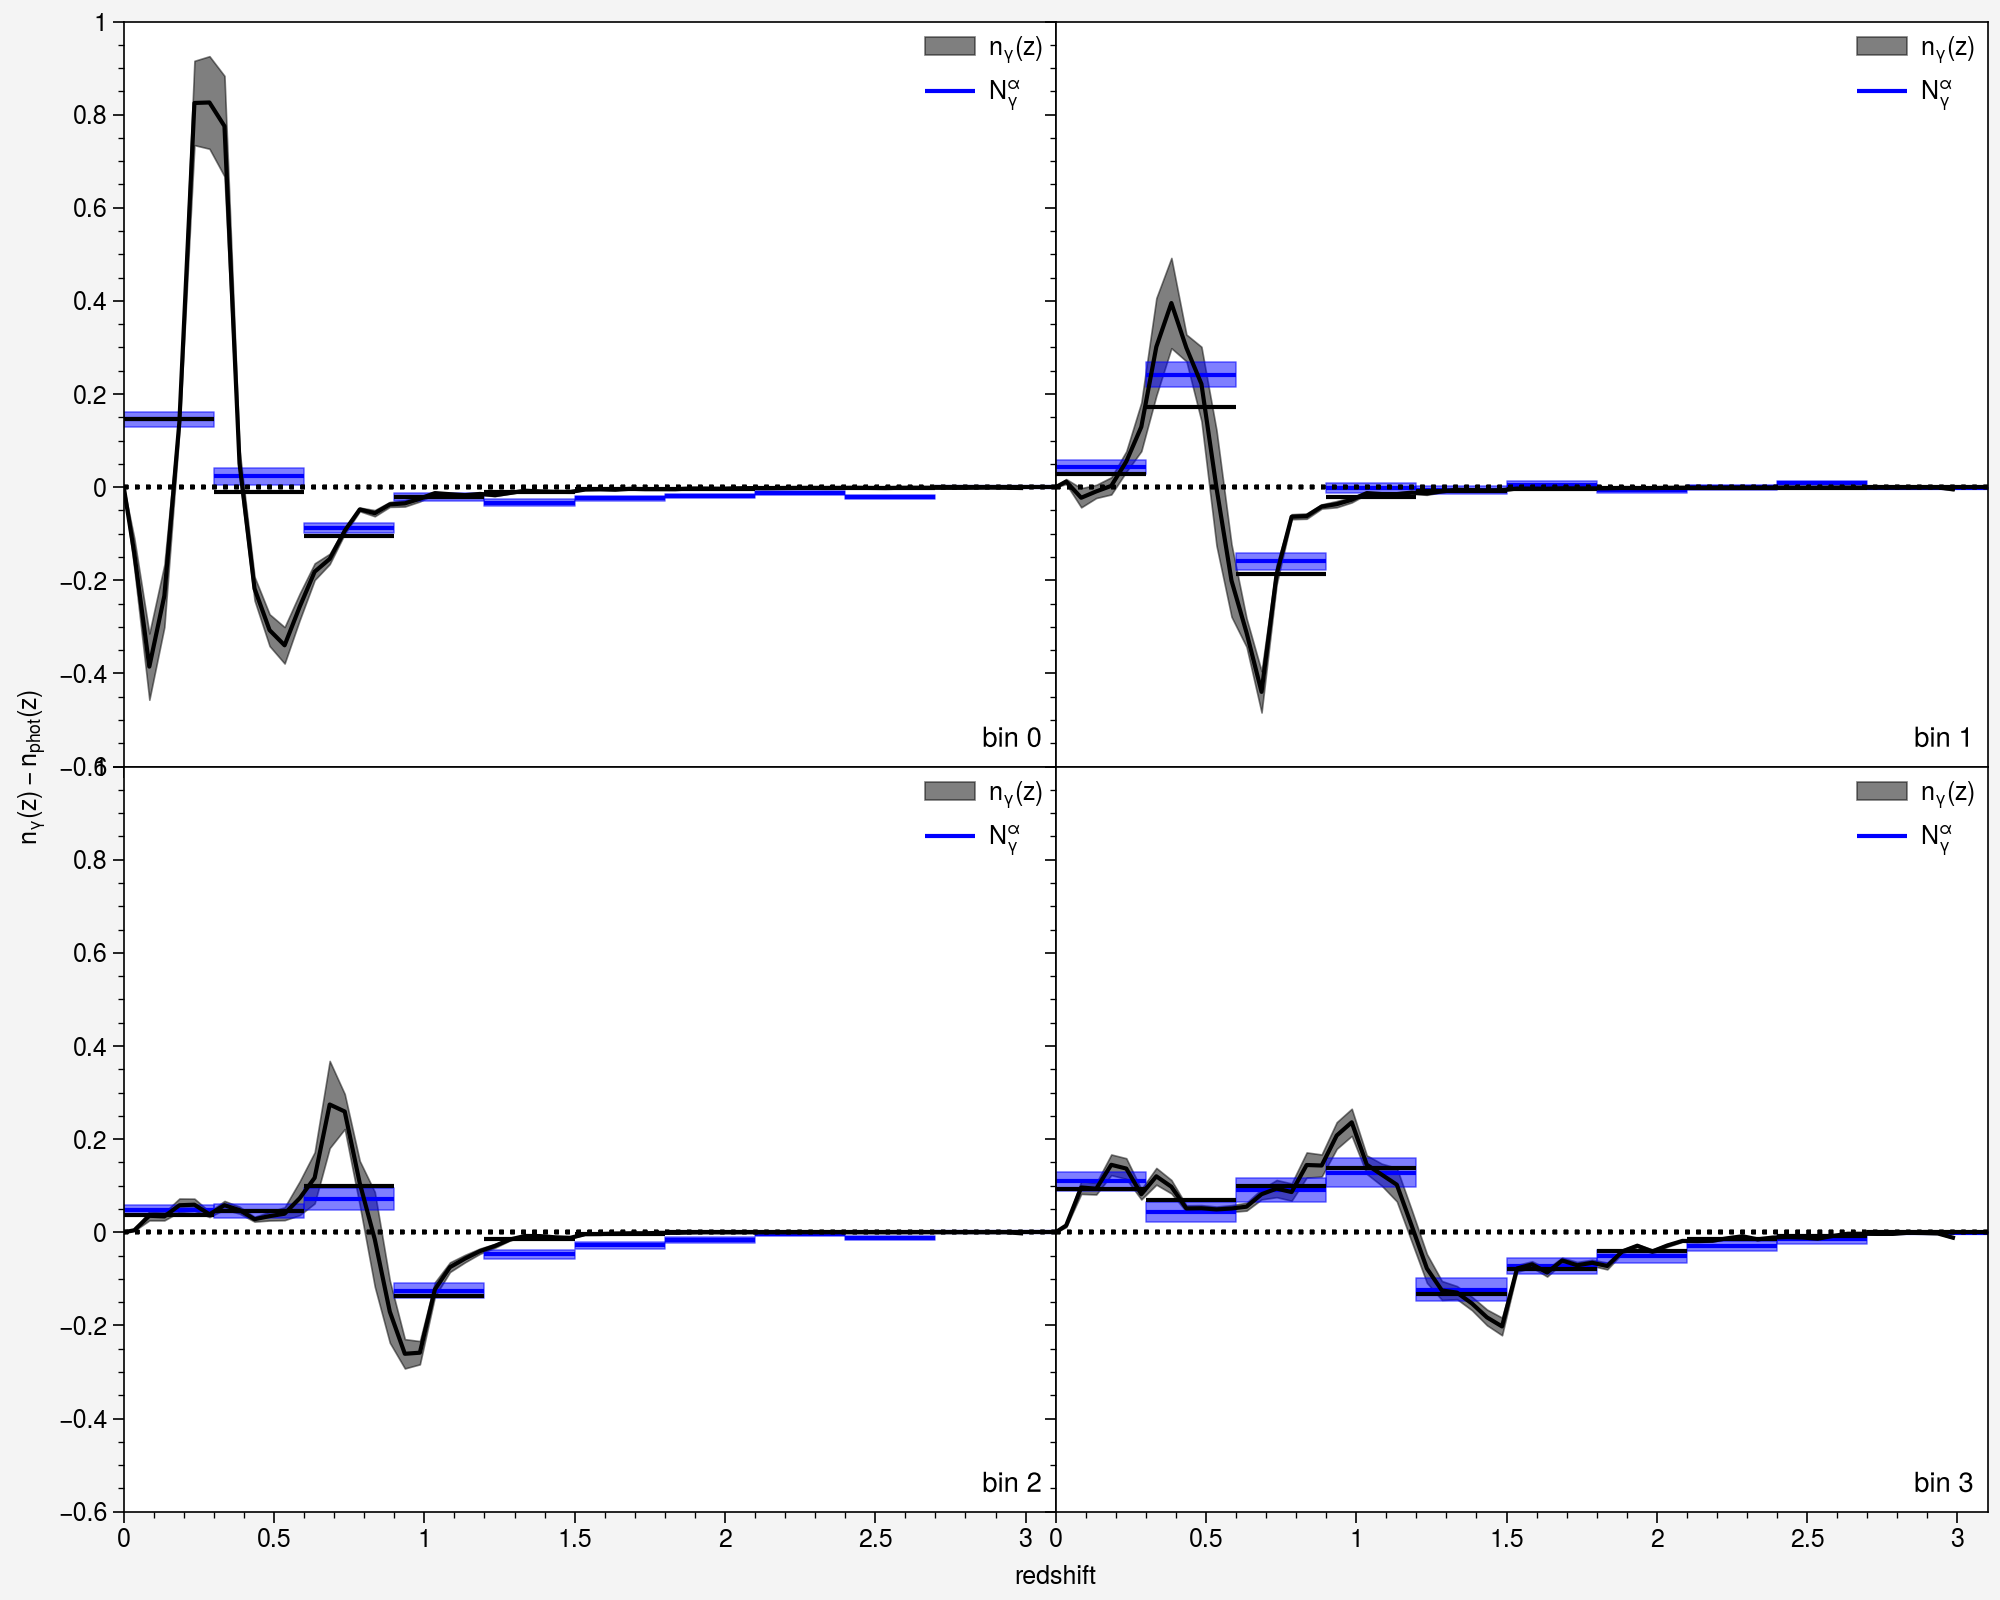

In [94]:
fig, axs = pplt.subplots(nrows=2, ncols=2, figsize=(10, 8), wspace=0, hspace=0)

sub_nmcal = 1

for bi in range(4):
    biy, bix = np.unravel_index(bi, (2, 2))
    ax = axs[biy, bix]

    ngammas = []
    zeros = np.zeros(1000)
    for i in range(1000):
        fmod = fmodel_mstudt4(
            ZVALS,
            samples[f"a0_b{bi}"][i],
            samples[f"a1_b{bi}"][i],
            samples[f"a2_b{bi}"][i],
            samples.get(f"a3_b{bi}", zeros)[i],
            samples.get(f"a4_b{bi}", zeros)[i],
            params[bi][0],
            params[bi][1],
        )
        gmod = samples[f"g_b{bi}"][i] * gmodel_template_cosmos()
        ngamma = (1.0 + fmod) * nzs[bi] + gmod
        ngammas.append(ngamma)
    ngammas = np.array(ngammas)
    ngamma_mn = np.mean(ngammas, axis=0)
    ngamma_sd = np.std(ngammas, axis=0)

    if not sub_nmcal:
        ax.plot(ZVALS, nzs[bi], drawstyle="steps-mid", label=r"$n_{\rm phot}(z)$", color="purple", linestyle="dashed")
        ax.plot(ZVALS, ngamma_mn, drawstyle="steps-mid", color="black", label=r"$n_\gamma(z)$")
        ax.errorbar(
            z,
            ngamma_mn,
            yerr=ngamma_sd,
            fmt="none",
            ecolor="black",
            alpha=0.5,
        )
    else:
        ax.fill_between(
            z,
            ngamma_mn - ngamma_sd - sub_nmcal * nzs[bi],
            ngamma_mn + ngamma_sd - sub_nmcal * nzs[bi],
            color="black",
            alpha=0.5,
            label=r"$n_\gamma(z)$",
        )
        ax.plot(z, ngamma_mn - sub_nmcal * nzs[bi], color="black")
        
    for i in range(10):
        nind = mn_pars.index((i, bi))
        bin_zmin, bin_zmax = zbins[i+1]
        bin_dz = bin_zmax - bin_zmin

        nmcal_val = sompz_integral(nzs[bi], z, bin_zmin, bin_zmax) / bin_dz
        if not sub_nmcal:
            ax.hlines(
                nmcal_val, 
                bin_zmin, 
                bin_zmax, 
                color="purple",
                # label="n(z) integral / delta z" if i == 0 else None,
            )
        
        nga_val = mn[nind] / bin_dz - sub_nmcal * nmcal_val
        nga_err = np.sqrt(cov[nind, nind]) / bin_dz
        ax.fill_between(
            [bin_zmin, bin_zmax],
            np.ones(2) * nga_val - nga_err,
            np.ones(2) * nga_val + nga_err,
            color="blue",
            alpha=0.5,
        )
                
        ax.hlines(
            mn[nind] / bin_dz - sub_nmcal * nmcal_val, 
            bin_zmin, 
            bin_zmax, 
            color="blue",
            label=r"$N_{\gamma}^{\alpha}$" if i == 0 else None,
        )
                
        ng_val = sompz_integral(ngamma_mn, z, bin_zmin, bin_zmax) / bin_dz
        ax.hlines(ng_val - sub_nmcal * nmcal_val, bin_zmin, bin_zmax, color="black")
    
        # ax.axvline(bin_zmin, color="black", linestyle="dotted")
        ax.axhline(0.0, color="black", linestyle="dotted")
        ax.grid(False)
        ax.legend(loc="ur", frameon=False, ncols=1)
    # ax.legend(loc="top", frameon=False)
    ax.format(
        xlim=(0, 3.1), 
        ylim=(-0.6, 1.0) if sub_nmcal else (-0.1, 4.0), 
        title=f"bin {bi}", 
        titleloc="lr" if sub_nmcal else "ul", 
        xlabel="redshift", 
        ylabel=r"$n_\gamma(z) - n_{\rm phot}(z)$" if sub_nmcal else r"$n_\gamma(z) or n_{\rm phot}(z)$",
    )